# Example 2


### Identifying the Reaction Pathway for a multi step SN2 Reaction

This workflow includes:

i) CREST conformer sampling,\
ii) Gaussian geometry optimization (B3LYP/def2tzvp),\ 
iii) fixing errors and imaginary frequencies of the output files,\
iv) ORCA, single-point energy corrections (SPC) using DLPNO-CCSD(T)/cc-pV(DT)Z, and\
v) Boltzmann weighted thermochemistry calculation with GoodVibes at 298.15 K.

#### Steps involved in this example

- Step 1: Import of AQME modules and necessary other python modules
- Step 2: Determine the constraints for the mutli step TSs (TS1 and TS2)
- Step 3: Creation of CSV with SMILES and constraints for TSs
- Step 4: Running CSEARCH (crest) on the CSV
- Step 5: Creation input files using QPREP 
    -  a. For TS with TS route line
    -  b. For other species with ground state/ intermediates route line
- Step 6: Run Gaussian calculations on HPC/or other computers where available
- Step 7: Checking with QCORR for corrections
- Step 8: Creation of DLPNO input files for ORCA single-point energy calculations
- Step 9: Analysis with goodvibes

###  Step 1: Import of AQME modules and necessary other python modules

In [1]:
import os, glob, subprocess
import shutil
from pathlib import Path
from aqme.csearch import csearch
from aqme.qprep import qprep
from aqme.qcorr import qcorr
from rdkit import Chem
import pandas as pd

[12:31:05] Enabling RDKit 2019.09.3 jupyter extensions
RDKit WARNING: [12:31:05] Enabling RDKit 2019.09.3 jupyter extensions


### Step 2: Determine the constraints for the mutli step TSs (TS1 and TS2)

In [2]:
smi1 = 'C(Cl)CCC.[Br-]'
mol1 = Chem.MolFromSmiles(smi1)
mol1 = Chem.AddHs(mol1)
for i,atom in enumerate(mol1.GetAtoms()):
    atom.SetAtomMapNum(i)
smi_new1 = Chem.MolToSmiles(mol1)
print('The new mapped smiles for checking numbers used in constraints is:', smi_new1)

The new mapped smiles for checking numbers used in constraints is: C([Cl:1])([C:2]([C:3]([C:4]([H:12])([H:13])[H:14])([H:10])[H:11])([H:8])[H:9])([H:6])[H:7].[Br-:5]


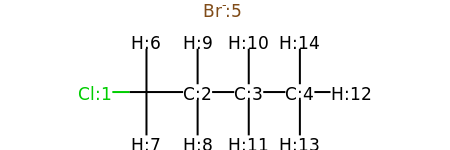

In [3]:
mol1
# distance and angle to fix are 
# constraits_dist = [[0,1,1.8],[0,5,2.1]]
# constraits_angle = [[1,0,5,180]]

In [4]:
smi2 = 'C(Br)CCC.[I-]'
mol2 = Chem.MolFromSmiles(smi2)
mol2 = Chem.AddHs(mol2)
for i,atom in enumerate(mol2.GetAtoms()):
    atom.SetAtomMapNum(i)
smi_new2 = Chem.MolToSmiles(mol2)
print('The new mapped smiles for checking numbers used in constraints is:', smi_new2)

The new mapped smiles for checking numbers used in constraints is: C([Br:1])([C:2]([C:3]([C:4]([H:12])([H:13])[H:14])([H:10])[H:11])([H:8])[H:9])([H:6])[H:7].[I-:5]


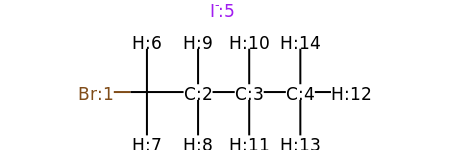

In [6]:
mol2
# distance and angle to fix are 
# constraits_dist = [[0,1,2.6],[0,5,2.9]]
# constraits_angle = [[1,0,5,180]]

### Step 3: Creation of CSV with SMILES and constraints for TSs

In [10]:
data = pd.read_csv('example2.csv')
data

,SMILES,code_name,constraints_dist,constraints_angle
0,[Br-],Reactant2,NaN,NaN
1,C(Cl)CCC,Reactant1,NaN,NaN
2,C([Cl:1])([C:2]([C:3]([C:4]([H:12])([H:13])[H:...,TS1_SN2,"[[0,1,1.8],[0,5,2.1]]","[[1,0,5,180]]"
3,[Cl-],Int1,NaN,NaN
4,C(Br)CCC,Int2,NaN,NaN
5,[I-],Reactant3,NaN,NaN
6,C([Br:1])([C:2]([C:3]([C:4]([H:12])([H:13])[H:...,TS2_SN2,"[[0,1,2.6],[0,5,2.9]]","[[1,0,5,180]]"
7,C(I)CCC,Product,NaN,NaN


### Step 4: Running CSEARCH (crest) on the CSV

In [9]:
# csearch(input='example2.csv',  program='crest', cregen=True, cregen_keywords='--ethr 0.1 --rthr 0.2 --bthr 0.3 --ewin 1')

### Step 5: Creation input files using QPREP 

#### a. For TS with TS route line

In [11]:
sdf_rdkit_files = ['CSEARCH/crest/TS1_SN2_crest.sdf','CSEARCH/crest/TS2_SN2_crest.sdf']

program = 'gaussian'
qm_input = 'B3LYP/def2tzvp opt=(ts,calcfc,noeigen) freq'
mem='40GB'
nprocs=36

qprep(files=sdf_rdkit_files,program=program,qm_input=qm_input,mem=mem,nprocs=nprocs)
 

o  TS1_SN2_crest successfully processed at /home/svss/Project-DBcg-Debug/aqme2_20220329/paper_examples_2/end-to-end-2-sn2-pes/QCALC

o  TS2_SN2_crest successfully processed at /home/svss/Project-DBcg-Debug/aqme2_20220329/paper_examples_2/end-to-end-2-sn2-pes/QCALC



In [12]:
sdf_rdkit_files = ['CSEARCH/crest/Int1_crest.sdf', 'CSEARCH/crest/Int2_crest.sdf','CSEARCH/crest/Product_crest.sdf','CSEARCH/crest/Reactant1_crest.sdf', 'CSEARCH/crest/Reactant2_crest.sdf', 'CSEARCH/crest/Reactant3_crest.sdf']

program = 'gaussian'
qm_input = 'B3LYP/def2tzvp opt freq'
mem='40GB'
nprocs=36

qprep(files=sdf_rdkit_files,program=program,qm_input=qm_input,mem=mem,nprocs=nprocs)

o  Int1_crest successfully processed at /home/svss/Project-DBcg-Debug/aqme2_20220329/paper_examples_2/end-to-end-2-sn2-pes/QCALC

o  Int2_crest successfully processed at /home/svss/Project-DBcg-Debug/aqme2_20220329/paper_examples_2/end-to-end-2-sn2-pes/QCALC

o  Product_crest successfully processed at /home/svss/Project-DBcg-Debug/aqme2_20220329/paper_examples_2/end-to-end-2-sn2-pes/QCALC

o  Reactant1_crest successfully processed at /home/svss/Project-DBcg-Debug/aqme2_20220329/paper_examples_2/end-to-end-2-sn2-pes/QCALC

o  Reactant2_crest successfully processed at /home/svss/Project-DBcg-Debug/aqme2_20220329/paper_examples_2/end-to-end-2-sn2-pes/QCALC

o  Reactant3_crest successfully processed at /home/svss/Project-DBcg-Debug/aqme2_20220329/paper_examples_2/end-to-end-2-sn2-pes/QCALC



### Step 6: Run Gaussian calculations on HPC/or other computers where available

In [13]:
# run gaussian externally

### Step 7: Checking with QCORR for corrections

In [16]:
# qcorr(files='QCALC/*.log')

### Step 8: creation of DLPNO input files for ORCA single-point energy calculations

In [17]:
qm_files = os.getcwd()+'/QCALC/success/*.log'
destination =  os.getcwd()+'/SP'

program = 'orca'

qm_input ='DLPNO-CCSD(T) def2-tzvpp def2-tzvpp/C\n'
qm_input += '%scf maxiter 500\n'
qm_input += 'end\n'
qm_input += '% mdci\n'
qm_input += 'Density None\n'
qm_input += 'end\n'
qm_input += '% elprop\n'
qm_input += 'Dipole False\n'
qm_input += 'end'
mem='4GB'
nprocs=8


qprep(destination=destination,files=qm_files,program=program, qm_input=qm_input,mem=mem,nprocs=nprocs, suffix='DLPNO')

o  Reactant1_crest_conf_3 successfully processed at /home/svss/Project-DBcg-Debug/aqme2_20220329/paper_examples_2/end-to-end-2-sn2-pes/SP

o  Reactant1_crest_conf_4 successfully processed at /home/svss/Project-DBcg-Debug/aqme2_20220329/paper_examples_2/end-to-end-2-sn2-pes/SP

o  Reactant2_crest_conf_1 successfully processed at /home/svss/Project-DBcg-Debug/aqme2_20220329/paper_examples_2/end-to-end-2-sn2-pes/SP

o  Reactant3_crest_conf_1 successfully processed at /home/svss/Project-DBcg-Debug/aqme2_20220329/paper_examples_2/end-to-end-2-sn2-pes/SP

o  TS1_SN2_crest_conf_1 successfully processed at /home/svss/Project-DBcg-Debug/aqme2_20220329/paper_examples_2/end-to-end-2-sn2-pes/SP

o  TS2_SN2_crest_conf_2 successfully processed at /home/svss/Project-DBcg-Debug/aqme2_20220329/paper_examples_2/end-to-end-2-sn2-pes/SP

o  Int2_crest_conf_4 successfully processed at /home/svss/Project-DBcg-Debug/aqme2_20220329/paper_examples_2/end-to-end-2-sn2-pes/SP

o  Product_crest_conf_1 successfully

### Step 9: Analysis with goodvibes

In [19]:
qm_files = os.getcwd()+'/QCALC/success/*.log'
orca_files = os.getcwd()+'/SP/*.out'

opt_files = glob.glob(qm_files)
spc_files = glob.glob(orca_files)
all_files = opt_files + spc_files

w_dir_main  = Path(os.getcwd())
GV_folder = w_dir_main.joinpath('GoodVibes_analysis')
GV_folder.mkdir(exist_ok=True, parents=True)

for file in all_files:
	shutil.copy(file, GV_folder)

os.chdir(GV_folder)
subprocess.run(['python', '-m', 'goodvibes', '--xyz','--pes', '../pes.yaml','--graph','../pes.yaml','-c','1','--spc', 'DLPNO', '*.log',])

os.chdir(w_dir_main)

   GoodVibes v3.0.1 2022/07/05 16:13:46
   REF: Luchini, G.; Alegre-Requena J. V.; Guan, Y.; Funes-Ardoiz, I.; Paton, R. S. (2019).
        GoodVibes: GoodVibes 3.0.1 http://doi.org/10.5281/zenodo.595246
   Requested: --xyz --pes ../pes.yaml --graph ../pes.yaml -c 1 --spc DLPNO 

   Temperature = 298.15 Kelvin   Concentration = 1.0 mol/l
   All energetic values below shown in Hartree unless otherwise specified.

o  Found vibrational scaling factor of 0.985 for B3LYP/def2TZVP level of theory
   REF: I. M. Alecu, unpublished (2011).

   Entropic quasi-harmonic treatment: frequency cut-off value of 100.0 wavenumbers will be applied.
   QS = Grimme: Using a mixture of RRHO and Free-rotor vibrational entropies.
   REF: Grimme, S. Chem. Eur. J. 2012, 18, 9955-9964


   Structure                                       E_SPC             E        ZPE         H_SPC        T.S     T.qh-S      G(T)_SPC   qh-G(T)_SPC
   ********************************************************************************